# CONTENTS

## 1. Feature Generation 

###  1. a. Functions to Create Features Given The tracking Frame
###  1. b. Creating the Dataframe/File that contains the features for all plays

## 2. Model Training

###   2. a. Splitting the data into week by week, we train on week 1-3
###   2. b. Training will happen on a single frame from the play, as this is what we will be working with 


## 3. Model Evaluation and Comparison to nflFastR
 

### 3. a. Evaluate the Success of the model on the test set. 
### 3. b. Compare the model against other xYac models, in this case its nflFastR

## *** LOAD LIBRARIES AND FILES *** 


In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb

# Contains the BDB 2021 Playfile Modified with NFL3D Columns (We can use this hehe)
play_file = pd.read_csv("plays_with_passer_expanded_with_z_norm.csv")

# Contains the 2018 PBP File from nflfastR, we need this to get some other information
pbp_2018 = pd.read_csv("/Users/Rishav/Downloads/play_by_play_2018.csv")

# We Join them by their gameID and playId
pbp_joined = pd.merge(play_file,pbp_2018,how = "left",left_on = ["gameId", "playId"] ,right_on = ["old_game_id", "play_id"])

# We only care about completed passes:
pbp_joined = pbp_joined[pbp_joined['passResult'] == "C"]

# Give me head
pbp_joined.head(5)


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (172,173,174,175,184,185,188,189,194,195,196,197,209,210,211,232,233,237,238,239,244,246,247,277) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0   X  X1      gameId  playId  \
0           1   1   0  2018090600      75   
3           4   4   3  2018090600     190   
5           6   6   5  2018090600     320   
8           9   9   8  2018090600     492   
9          10  10   9  2018090600     521   

                                     playDescription  quarter  down_x  \
0  (15:00) M.Ryan pass short right to J.Jones pus...        1       1   
3  (13:01) (Shotgun) M.Ryan pass deep left to J.J...        1       3   
5  (10:10) (Shotgun) N.Foles pass short left to N...        1       2   
8  (7:01) M.Ryan pass short left to T.Coleman pus...        1       2   
9  (6:19) M.Ryan pass short left to A.Hooper to P...        1       1   

   yardsToGo possessionTeam  ...                           receiver_id  \
0         15            ATL  ...  32013030-2d30-3032-3739-3434d4d3846d   
3         10            ATL  ...  32013030-2d30-3032-3739-3434d4d3846d   
5          8            PHI  ...  32013030-2d30-3033-3135-3439d46a53e9   
8         13            ATL  ...  32013030-2d30-3033-3230-35386984de69   
9         10            ATL  ...  32013030-2d30-3033-3233-39328d4eeab0   

      name  jersey_number                                    id    qb_epa  \
0   M.Ryan            2.0  32013030-2d30-3032-3631-34338634c9b6  0.850118   
3   M.Ryan            2.0  32013030-2d30-3032-3631-34338634c9b6  3.743511   
5  N.Foles            9.0  32013030-2d30-3032-3935-3637b84f8e70 -0.245429   
8   M.Ryan            2.0  32013030-2d30-3032-3631-34338634c9b6  2.453459   
9   M.Ryan            2.0  32013030-2d30-3032-3631-34338634c9b6 -0.116232   

   xyac_epa  xyac_mean_yardage xyac_median_yardage xyac_success   xyac_fd  
0  0.564952           3.515882                 2.0     0.998706  0.147457  
3  0.592946           5.718961                 3.0     1.000000  1.000000  
5  0.763274           4.152079                 2.0     0.622114  0.374009  
8  1.440003          12.512437                11.0     0.414119  0.153063  
9  0.785621           3.608658                 3.0     0.682132  0.160555  

[5 rows x 393 columns]

In [2]:
### TRACKING DATA RELATED STUFF ###

# Replace this with your week1 file location, just loading one for now. 
week1 = pd.read_csv("/Users/Rishav/Downloads/nfl-big-data-bowl-2021/week1.csv")

# We also only care about the frame at which a catch happens, so lets remove all the other crap
week1 = week1[week1["event"] == "pass_outcome_caught"]


for i in range(2,18):
    print("Adding week %d" % i)
    current_week = pd.read_csv("/Users/Rishav/Downloads/nfl-big-data-bowl-2021/week%d.csv" % i)

# We also only care about the frame at which a catch happens, so lets remove all the other crap
    current_week = current_week[current_week["event"] == "pass_outcome_caught"]
    week1 = week1.append(current_week, ignore_index = True)



week1.head(5)

Adding week 2
Adding week 3
Adding week 4
Adding week 5
Adding week 6
Adding week 7
Adding week 8
Adding week 9
Adding week 10
Adding week 11
Adding week 12
Adding week 13
Adding week 14
Adding week 15
Adding week 16
Adding week 17


time      x      y     s     a   dis       o     dir  \
0  2018-09-07T01:07:19.700Z  96.10  27.82  0.99  1.14  0.10  327.40  311.41   
1  2018-09-07T01:07:19.700Z  81.74  49.08  7.94  2.37  0.80    0.01  347.39   
2  2018-09-07T01:07:19.700Z  81.48  50.13  4.93  3.07  0.49  326.77  358.86   
3  2018-09-07T01:07:19.700Z  81.41  19.08  4.65  2.84  0.46  355.18  325.16   
4  2018-09-07T01:07:19.700Z  76.75  36.60  2.82  1.85  0.28   33.31  332.72   

                 event      nflId      displayName  jerseyNumber position  \
0  pass_outcome_caught      310.0        Matt Ryan           2.0       QB   
1  pass_outcome_caught    79848.0  Malcolm Jenkins          27.0       SS   
2  pass_outcome_caught  2495454.0      Julio Jones          11.0       WR   
3  pass_outcome_caught  2495613.0     Corey Graham          24.0       FS   
4  pass_outcome_caught  2533040.0     Mohamed Sanu          12.0       WR   

   frameId  team      gameId  playId playDirection  route  
0       52  away  2018090600      75          left    NaN  
1       52  home  2018090600      75          left    NaN  
2       52  away  2018090600      75          left  HITCH  
3       52  home  2018090600      75          left    NaN  
4       52  away  2018090600      75          left  HITCH

## 1. Feature Generation

### 1. a. Functions to Create Features

In [3]:
def find_potential_blockers(row, df):
    d = row["distance_from_recv"]
    val = len(df[df["distance_from_recv"] <= d]) - 1
    return val
    

### 1. b. Create Dataframe that contains the features 

In [177]:
mapping = {'DB': 'DB', 'CB': 'DB', 'S': 'S', 'SS': 'S', 'FS': 'S', 'WR': 'WR', 'MLB': 'LB', 'OLB': 'LB', 'ILB': 'LB', 'LB': 'LB', 'DL': 'DL', 'DT':'DL', 'DE': 'DL', 'NT': 'DL', 'QB': 'QB', 'RB': 'RB', 'HB': 'RB', 'TE': 'TE', 'P': 'ST', 'K': 'ST', 'LS':'ST', 'FB': 'FB'}

feature_frame = []

import time
pd.options.mode.chained_assignment = None 
print(len(pbp_joined))
#pbp_joined_week1 = pbp_joined[(pbp_joined["week"] == 1) | (pbp_joined["week"] == 2) | (pbp_joined["week"] == 3)]

for i,r in pbp_joined.iterrows(): 
    try:
        a = time.time()


        temp_frame = {}
        temp_frame['yardsToGo'] = r['yardsToGo']

        b = r['personnelO'].split(", ")
        persO = {a.split(" ")[1]:int(a.split(" ")[0]) for a in b}
        #print(persO)
        temp_frame['num_RB'] = persO['RB']
        temp_frame['num_TE'] = persO['TE']
        temp_frame['num_WR'] = persO['WR']

        b = r['personnelD'].split(", ")
        persD = {a.split(" ")[1]:int(a.split(" ")[0]) for a in b}
        temp_frame['num_DL'] = persD['DL']
        temp_frame['num_LB'] = persD['LB']
        temp_frame['num_DB'] = persD['DB']

        temp_frame['yardline_100'] = r['yardline_100']
        temp_frame['air_yards'] = r['air_yards']
        temp_frame['distance_to_goal'] = r['yardline_100'] - r['air_yards']
        temp_frame['distance_to_sticks'] = r['air_yards'] - r['ydstogo']
        temp_frame['ball_velocity'] = r["v"]
        temp_frame['launch_angle'] = r["launch_angle"]

        tracking_frames = week1[(week1['playId'] == r['playId']) & (week1['gameId'] == r['gameId'])]
        tracking_frames['los_norm'] = 40
        los = tracking_frames[tracking_frames['displayName'] == "Football"].iloc[0]["x"]
        tracking_frames['x'] = tracking_frames['x']-(los-tracking_frames['los_norm'])
        tracking_frames.loc[tracking_frames.playDirection == 'left', 'x'] = (tracking_frames['los_norm']-tracking_frames['x'])+tracking_frames['los_norm']
        tracking_frames.loc[tracking_frames.playDirection == 'left', 'o'] = (tracking_frames['o']+180) % 360
        tracking_frames.loc[tracking_frames.playDirection == 'left', 'dir'] = (tracking_frames['dir']+180) % 360
        recv_num = r["receiver_jersey_number"]
        recv_row = tracking_frames[tracking_frames['jerseyNumber'] == recv_num]
        #print(recv_num)
        #print(tracking_frames)
        recv_x = recv_row.iloc[0]["x"]
        recv_y = recv_row.iloc[0]["y"]
        recv_team = recv_row.iloc[0]["team"]
        
        temp_frame['y'] = recv_y

        other_team_name = "home" if recv_team == "away" else "away"

        this_team_frames = tracking_frames[tracking_frames['team'] == recv_team]
        this_team_frames.loc[:,'distance_from_recv'] =  ((this_team_frames['x']-recv_x)**2  + (this_team_frames['y']-recv_y)**2)**0.5
        this_team_frames.loc[:,'recv_x_diff'] = this_team_frames['x']-recv_x 

        this_team_frames = this_team_frames.sort_values("distance_from_recv")

        other_team_frames = tracking_frames[tracking_frames['team'] == other_team_name]
        temp_frame['receiver_speed'] = recv_row.iloc[0]["s"]
        temp_frame['receiver_accel'] = recv_row.iloc[0]["a"]
        temp_frame['receiver_dir'] = recv_row.iloc[0]["dir"]
        temp_frame['receiver_o'] = recv_row.iloc[0]["dir"]
        temp_frame['receiver_WR'] = 1 if recv_row.iloc[0]["position"] == "WR" else 0
        temp_frame['receiver_RB'] = 1 if recv_row.iloc[0]["position"] == "RB" else 0
        temp_frame['receiver_TE'] = 1 if recv_row.iloc[0]["position"] == "TE" else 0

        other_team_frames.loc[:,'distance_from_recv'] =  ((other_team_frames['x']-recv_x)**2  + (other_team_frames['y']-recv_y)**2)**0.5
        other_team_frames.loc[:,'recv_x_diff'] = other_team_frames['x']-recv_x
        other_team_frames.loc[:,'recv_y_diff'] = other_team_frames['y']-recv_y 
        other_team_frames = other_team_frames.sort_values("distance_from_recv")

        other_team_frames.loc[:,'potential_blockers'] =  other_team_frames.apply (lambda row: find_potential_blockers(row, this_team_frames), axis=1)
        
        temp_frame['1-closest-defender_pos_DB'] = 1 if (mapping[other_team_frames.iloc[0]["position"]] == "DB") else 0
        temp_frame['1-closest-defender_pos_LB'] = 1 if (mapping[other_team_frames.iloc[0]["position"]] == "LB") else 0
        temp_frame['1-closest-defender_pos_DL'] = 1 if (mapping[other_team_frames.iloc[0]["position"]] == "DL") else 0

        temp_frame['1-closest-defender-distance'] = other_team_frames.iloc[0]["distance_from_recv"]
        temp_frame['2-closest-defender-distance'] = other_team_frames.iloc[1]["distance_from_recv"]
        temp_frame['3-closest-defender-distance'] = other_team_frames.iloc[2]["distance_from_recv"]
        temp_frame['4-closest-defender-distance'] = other_team_frames.iloc[3]["distance_from_recv"]
        temp_frame['5-closest-defender-distance'] = other_team_frames.iloc[4]["distance_from_recv"]
        
        temp_frame['1-closest-defender-x'] = other_team_frames.iloc[0]["recv_x_diff"]
        temp_frame['2-closest-defender-x'] = other_team_frames.iloc[1]["recv_x_diff"]
        temp_frame['3-closest-defender-x'] = other_team_frames.iloc[2]["recv_x_diff"]
        temp_frame['4-closest-defender-x'] = other_team_frames.iloc[3]["recv_x_diff"]
        temp_frame['5-closest-defender-x'] = other_team_frames.iloc[4]["recv_x_diff"]
        
        temp_frame['1-closest-defender-y'] = other_team_frames.iloc[0]["recv_y_diff"]
        temp_frame['2-closest-defender-y'] = other_team_frames.iloc[1]["recv_y_diff"]
        temp_frame['3-closest-defender-y'] = other_team_frames.iloc[2]["recv_y_diff"]
        temp_frame['4-closest-defender-y'] = other_team_frames.iloc[3]["recv_y_diff"]
        temp_frame['5-closest-defender-y'] = other_team_frames.iloc[4]["recv_y_diff"]

        temp_frame['1-closest-defender-speed'] = other_team_frames.iloc[0]["s"]
        temp_frame['2-closest-defender-speed'] = other_team_frames.iloc[1]["s"]
        temp_frame['3-closest-defender-speed'] = other_team_frames.iloc[2]["s"]
        temp_frame['4-closest-defender-speed'] = other_team_frames.iloc[3]["s"]
        temp_frame['5-closest-defender-speed'] = other_team_frames.iloc[4]["s"]

        temp_frame['1-closest-defender-a'] = other_team_frames.iloc[0]["a"]
        temp_frame['2-closest-defender-a'] = other_team_frames.iloc[1]["a"]
        temp_frame['3-closest-defender-a'] = other_team_frames.iloc[2]["a"]
        temp_frame['4-closest-defender-a'] = other_team_frames.iloc[3]["a"]
        temp_frame['5-closest-defender-a'] = other_team_frames.iloc[4]["a"]
        
        temp_frame['1-closest-defender-o'] = other_team_frames.iloc[0]["o"]
        temp_frame['2-closest-defender-o'] = other_team_frames.iloc[1]["o"]
        temp_frame['3-closest-defender-o'] = other_team_frames.iloc[2]["o"]
        temp_frame['4-closest-defender-o'] = other_team_frames.iloc[3]["o"]
        temp_frame['5-closest-defender-o'] = other_team_frames.iloc[4]["o"]
        
        temp_frame['1-closest-defender-dir'] = other_team_frames.iloc[0]["dir"]
        temp_frame['2-closest-defender-dir'] = other_team_frames.iloc[1]["dir"]
        temp_frame['3-closest-defender-dir'] = other_team_frames.iloc[2]["dir"]
        temp_frame['4-closest-defender-dir'] = other_team_frames.iloc[3]["dir"]
        temp_frame['5-closest-defender-dir'] = other_team_frames.iloc[4]["dir"]

        temp_frame['1-closest-defender-potentialBlockers'] = other_team_frames.iloc[0]["potential_blockers"]
        temp_frame['2-closest-defender-potentialBlockers'] = other_team_frames.iloc[1]["potential_blockers"]
        temp_frame['3-closest-defender-potentialBlockers'] = other_team_frames.iloc[2]["potential_blockers"]
        temp_frame['4-closest-defender-potentialBlockers'] = other_team_frames.iloc[3]["potential_blockers"]
        temp_frame['5-closest-defender-potentialBlockers'] = other_team_frames.iloc[4]["potential_blockers"]

        temp_frame['yac'] = r['yards_after_catch']
        temp_frame['gameId'] = r['gameId']
        temp_frame['playId'] = r['playId']
        temp_frame['week'] = r['week']
        temp_frame['xyac_nflfastR'] = r['xyac_mean_yardage']
 
        feature_frame.append(temp_frame)
        b = time.time()
        print(b-a)
        #print(temp_frame)
        print(r['week'])
        #break
    except:
        print("Fuck")
        print(r['week'])
        pass
        
#     except Exception as e:
#         print(r['gameId'], r['playId'])
#         break

    

a = pd.DataFrame(feature_frame)
a.head(5)


11267
0.05658268928527832
1
0.050570011138916016
1
0.05242013931274414
1
0.055767059326171875
1
0.041794776916503906
1
0.052752017974853516
1
0.05075383186340332
1
0.04610466957092285
1
0.03963899612426758
1
0.0401921272277832
1
0.042099952697753906
1
0.044240713119506836
1
0.04634284973144531
1
0.04715919494628906
1
0.052474021911621094
1
0.05051088333129883
1
0.044075727462768555
1
0.046133995056152344
1
0.04161190986633301
1
0.04429483413696289
1
0.043385982513427734
1
0.04462695121765137
1
0.04108071327209473
1
0.04003715515136719
1
0.03960895538330078
1
0.040925025939941406
1
0.04481697082519531
1
0.040071725845336914
1
0.043061017990112305
1
0.041342973709106445
1
0.040702104568481445
1
0.045655012130737305
1
0.04184985160827637
1
0.04076504707336426
1
0.043057918548583984
1
0.04320096969604492
1
0.04403567314147949
1
0.040296077728271484
1
0.04042482376098633
1
0.04210805892944336
1
0.04011392593383789
1
0.04841017723083496
1
0.04265594482421875
1
0.04184603691101074
1
0.0416548

0.048055171966552734
1
0.04481196403503418
1
0.04555177688598633
1
0.0424647331237793
1
0.04173994064331055
1
0.04181098937988281
1
0.04604983329772949
1
0.04092812538146973
1
0.04057717323303223
1
0.04370832443237305
1
0.045365095138549805
1
0.0473480224609375
1
0.04191112518310547
1
0.04097104072570801
1
0.041882991790771484
1
0.04550600051879883
1
0.04620194435119629
1
0.04517006874084473
1
0.03985309600830078
1
0.03926396369934082
1
Fuck
1
0.05047869682312012
1
0.0432279109954834
1
0.040389060974121094
1
0.04221367835998535
1
0.04352402687072754
1
0.04082918167114258
1
0.04878091812133789
1
0.040643930435180664
1
0.04097938537597656
1
0.039673805236816406
1
0.04032325744628906
1
0.0446319580078125
1
0.0426020622253418
1
0.04379582405090332
1
0.04796791076660156
1
0.05058097839355469
1
0.0481419563293457
1
0.04537701606750488
1
0.040246009826660156
1
Fuck
1
0.03949713706970215
1
0.040772199630737305
1
0.042723655700683594
1
0.0412747859954834
1
0.03959798812866211
1
0.03935098648071

0.04646015167236328
2
Fuck
2
0.04262685775756836
2
0.039652109146118164
2
0.04367995262145996
2
0.04273676872253418
2
0.04329800605773926
2
0.044287919998168945
2
0.047693729400634766
2
0.04359722137451172
2
0.043105125427246094
2
0.043801069259643555
2
0.05042409896850586
2
0.0427248477935791
2
0.04206585884094238
2
0.0400538444519043
2
0.04134106636047363
2
0.04384589195251465
2
0.049818992614746094
2
0.050512075424194336
2
0.052147865295410156
2
0.05794692039489746
2
0.05045604705810547
2
0.04519987106323242
2
Fuck
2
0.05492281913757324
2
0.05095386505126953
2
Fuck
2
0.04399514198303223
2
0.04303789138793945
2
0.06754493713378906
2
0.061476945877075195
2
0.04786515235900879
2
0.07100987434387207
2
0.04377388954162598
2
0.045423030853271484
2
0.04694199562072754
2
0.05148005485534668
2
0.05690908432006836
2
0.052520751953125
2
0.050755977630615234
2
0.042730093002319336
2
Fuck
2
0.044049978256225586
2
0.04233694076538086
2
0.0502171516418457
2
0.05243325233459473
2
0.0560362339019775

0.044283151626586914
2
0.04425787925720215
2
0.04138326644897461
2
0.04376816749572754
2
0.044976234436035156
2
0.04263496398925781
2
0.04655122756958008
2
0.044973134994506836
2
0.05816483497619629
2
0.04466986656188965
2
0.04984879493713379
2
0.04667520523071289
2
0.04311180114746094
2
0.043340206146240234
2
0.04213690757751465
2
0.04570293426513672
2
0.047766923904418945
2
0.04132890701293945
2
0.040872812271118164
2
0.04243898391723633
2
0.04147696495056152
2
0.048227787017822266
2
0.04636716842651367
2
0.04434013366699219
2
0.04363512992858887
2
0.04816007614135742
2
0.04666304588317871
2
0.042127132415771484
2
0.04471182823181152
2
0.043791770935058594
2
0.05413103103637695
2
0.05501699447631836
2
Fuck
2
0.05951094627380371
2
0.05600380897521973
2
0.05299496650695801
2
0.04561901092529297
2
0.04528999328613281
2
0.043000221252441406
2
0.041378021240234375
2
0.04408383369445801
2
0.05659914016723633
2
0.058461904525756836
2
0.04689311981201172
2
0.04458284378051758
2
0.05155825614

0.04557609558105469
3
0.05255722999572754
3
0.0551910400390625
3
0.055355072021484375
3
0.07077288627624512
3
0.05010509490966797
3
0.05552482604980469
3
0.047339677810668945
3
0.04506421089172363
3
0.0690762996673584
3
0.06543827056884766
3
0.059307098388671875
3
0.07120203971862793
3
0.05573892593383789
3
0.0479121208190918
3
0.056511878967285156
3
0.04444384574890137
3
0.04196882247924805
3
0.04739022254943848
3
0.04522705078125
3
0.06587791442871094
3
0.07817482948303223
3
0.06727981567382812
3
0.05335378646850586
3
0.06385207176208496
3
0.08589482307434082
3
0.07383179664611816
3
0.07041716575622559
3
0.06957387924194336
3
Fuck
3
0.0856330394744873
3
0.0657811164855957
3
0.06906700134277344
3
0.05864882469177246
3
0.05769991874694824
3
0.0566258430480957
3
0.048391103744506836
3
0.047513723373413086
3
0.043884992599487305
3
0.05532097816467285
3
0.056710243225097656
3
0.058728933334350586
3
0.0491640567779541
3
0.044523000717163086
3
0.04542207717895508
3
0.04983091354370117
3
0.0

0.054476022720336914
3
0.05178689956665039
3
0.05105781555175781
3
0.04882383346557617
3
0.04557299613952637
3
0.0481410026550293
3
0.04902291297912598
3
0.04480481147766113
3
0.044724225997924805
3
0.04357409477233887
3
0.04752802848815918
3
0.04874014854431152
3
0.046382904052734375
3
0.04619479179382324
3
0.04734611511230469
3
0.0483551025390625
3
0.049429893493652344
3
0.047820091247558594
3
0.04705619812011719
3
0.045351266860961914
3
0.04475903511047363
3
0.050546884536743164
3
0.044647932052612305
3
0.04444003105163574
3
0.04344987869262695
3
0.04598402976989746
3
0.046974897384643555
3
0.04524397850036621
3
0.04585599899291992
3
0.04490327835083008
3
0.04890012741088867
3
0.04648184776306152
3
0.04508614540100098
3
0.04569816589355469
3
0.04688882827758789
3
0.04645180702209473
3
0.05011415481567383
3
0.04547381401062012
3
0.04422187805175781
3
0.042944908142089844
3
0.044259071350097656
3
0.046633005142211914
3
0.04751324653625488
3
0.04590916633605957
3
0.043847084045410156
3

0.04513406753540039
4
0.04798102378845215
4
0.04472923278808594
4
0.04524517059326172
4
0.0465548038482666
4
0.04648613929748535
4
0.04504275321960449
4
0.043849945068359375
4
0.042053937911987305
4
0.0432891845703125
4
0.044651031494140625
4
0.04585385322570801
4
0.04275703430175781
4
0.04625892639160156
4
0.04343390464782715
4
0.04466390609741211
4
0.044571876525878906
4
0.0435938835144043
4
0.04444074630737305
4
0.04580402374267578
4
0.04505610466003418
4
0.04496598243713379
4
0.04294705390930176
4
Fuck
4
0.04776906967163086
4
0.049665212631225586
4
0.05222678184509277
4
0.04580497741699219
4
0.04827594757080078
4
0.05256295204162598
4
0.04883408546447754
4
Fuck
4
0.04667091369628906
4
0.045670270919799805
4
0.047141313552856445
4
0.04654693603515625
4
0.04780387878417969
4
0.05128192901611328
4
0.0438079833984375
4
0.04445695877075195
4
0.04697132110595703
4
0.048597097396850586
4
0.04892230033874512
4
0.04948282241821289
4
0.051423072814941406
4
0.04513406753540039
4
0.04730868339

0.04884791374206543
4
0.04372882843017578
4
0.04476284980773926
4
0.046617984771728516
4
0.04850506782531738
4
0.04957103729248047
4
0.04537796974182129
4
0.04536914825439453
4
0.046076059341430664
4
0.0480499267578125
4
0.04778003692626953
4
0.04912686347961426
4
0.04968905448913574
4
0.04780268669128418
4
0.051312923431396484
4
0.04751944541931152
4
0.04824185371398926
4
0.04639720916748047
4
0.048004865646362305
4
0.04323625564575195
4
0.04567718505859375
4
0.047740936279296875
4
0.04881906509399414
4
0.04664802551269531
4
0.043589115142822266
4
0.04430890083312988
4
0.04618120193481445
4
0.04479098320007324
4
0.046607255935668945
4
0.042550086975097656
4
0.044831037521362305
4
0.04591536521911621
4
0.045348167419433594
4
Fuck
4
0.0438380241394043
4
0.04244589805603027
4
0.04735827445983887
4
0.048438072204589844
4
0.044255971908569336
4
Fuck
4
0.043942928314208984
4
0.04444622993469238
4
0.046003103256225586
4
0.046263933181762695
4
0.04459786415100098
4
0.04351186752319336
4
0.043

0.04619479179382324
5
0.04815387725830078
5
0.04815816879272461
5
0.04649710655212402
5
0.04569125175476074
5
0.046613216400146484
5
0.0454258918762207
5
0.04904985427856445
5
0.04678916931152344
5
0.0456540584564209
5
0.04931282997131348
5
0.04710888862609863
5
0.04514670372009277
5
0.04862475395202637
5
0.04689502716064453
5
0.05451631546020508
5
0.045120954513549805
5
0.04524588584899902
5
0.045232295989990234
5
0.044936180114746094
5
0.051744937896728516
5
0.046862125396728516
5
0.05135202407836914
5
0.04965090751647949
5
0.04897809028625488
5
0.05115222930908203
5
0.04971575736999512
5
0.044165849685668945
5
0.045845985412597656
5
0.04484724998474121
5
0.04614400863647461
5
0.04651379585266113
5
0.04505515098571777
5
0.04698491096496582
5
0.048317909240722656
5
0.04881596565246582
5
0.045918941497802734
5
0.04430794715881348
5
0.04635190963745117
5
0.0451359748840332
5
0.04390072822570801
5
0.051174163818359375
5
0.04901909828186035
5
0.04768800735473633
5
0.04440116882324219
5
0.

0.04451799392700195
5
0.0465240478515625
5
0.0439610481262207
5
0.04353499412536621
5
0.04326891899108887
5
0.043344974517822266
5
0.04513192176818848
5
0.04262900352478027
5
0.04326581954956055
5
0.04341006278991699
5
Fuck
5
0.04534125328063965
5
0.047698020935058594
5
0.04408907890319824
5
0.04258894920349121
5
0.04393172264099121
5
0.04723000526428223
5
0.0459139347076416
5
0.04630684852600098
5
0.046888113021850586
5
0.046495914459228516
5
0.04992365837097168
5
Fuck
5
0.04688310623168945
5
0.04627513885498047
5
0.04678916931152344
5
0.04385089874267578
5
0.04843497276306152
5
0.04555320739746094
5
0.0453341007232666
5
0.04511094093322754
5
0.05057096481323242
5
0.054595947265625
5
0.04894304275512695
5
0.04436087608337402
5
0.04240107536315918
5
0.04385185241699219
5
0.04828000068664551
5
0.04717683792114258
5
0.04512977600097656
5
0.04471302032470703
5
0.04448676109313965
5
0.04466104507446289
5
0.04723000526428223
5
0.04469609260559082
5
0.04504108428955078
5
0.04265093803405762


0.0460052490234375
6
0.046421051025390625
6
Fuck
6
0.04653429985046387
6
0.04490327835083008
6
0.042246103286743164
6
0.0462498664855957
6
0.04711508750915527
6
0.04704928398132324
6
0.044908761978149414
6
0.04698300361633301
6
0.04644608497619629
6
0.04664325714111328
6
0.04723310470581055
6
0.043853759765625
6
0.04488968849182129
6
0.04709601402282715
6
0.04597616195678711
6
0.04308199882507324
6
0.04379105567932129
6
0.04601311683654785
6
0.04581809043884277
6
0.046257972717285156
6
0.043602943420410156
6
0.044213056564331055
6
0.045710086822509766
6
0.04464077949523926
6
0.049714088439941406
6
0.048432111740112305
6
Fuck
6
0.04249310493469238
6
0.04294705390930176
6
Fuck
6
0.0463109016418457
6
0.04551506042480469
6
0.04435992240905762
6
0.045806169509887695
6
0.043356895446777344
6
0.045638084411621094
6
0.04661989212036133
6
0.04329180717468262
6
0.04418802261352539
6
0.04382181167602539
6
0.046839237213134766
6
0.04549694061279297
6
0.04401993751525879
6
0.04453611373901367
6
Fuc

0.04580092430114746
6
0.047286033630371094
6
0.0452878475189209
6
0.04897189140319824
6
0.04757881164550781
6
0.0495600700378418
6
0.04965782165527344
6
0.043103933334350586
6
0.04686284065246582
6
0.04600024223327637
6
Fuck
6
0.0508570671081543
6
0.0492100715637207
6
0.04775500297546387
6
0.04623293876647949
7
0.04744601249694824
7
0.0483860969543457
7
Fuck
7
0.04408979415893555
7
0.04536890983581543
7
0.046269893646240234
7
0.047779083251953125
7
0.04904294013977051
7
0.04735422134399414
7
0.048659324645996094
7
0.04797816276550293
7
0.04620790481567383
7
0.04816603660583496
7
0.04360795021057129
7
0.0441431999206543
7
0.04579281806945801
7
0.046279191970825195
7
0.05283379554748535
7
0.04555010795593262
7
0.04465174674987793
7
0.04667091369628906
7
0.04657936096191406
7
Fuck
7
0.04489398002624512
7
0.04861807823181152
7
0.043725013732910156
7
0.04626798629760742
7
0.04622602462768555
7
0.04749274253845215
7
0.04636979103088379
7
0.04648590087890625
7
0.05230402946472168
7
0.04712009

0.0670168399810791
7
Fuck
7
0.07187080383300781
7
0.06225180625915527
7
0.05066084861755371
7
0.047612905502319336
7
0.04734301567077637
7
0.04662823677062988
7
0.04870104789733887
7
Fuck
7
0.04850912094116211
7
0.05221366882324219
7
0.04654693603515625
7
0.04646110534667969
7
0.05187201499938965
7
0.04842805862426758
7
0.05344414710998535
7
0.04753684997558594
7
0.04460000991821289
7
0.04732203483581543
7
0.046295881271362305
7
0.04844093322753906
7
0.04626035690307617
7
0.04560112953186035
7
0.04574394226074219
7
0.04631686210632324
7
0.04997396469116211
7
0.043637990951538086
7
0.04494476318359375
7
0.04552006721496582
7
0.05183911323547363
7
0.049160003662109375
7
0.0499110221862793
7
0.048948049545288086
7
0.05099010467529297
7
0.047126054763793945
7
0.0465238094329834
7
0.045479774475097656
7
0.04757285118103027
7
0.047094106674194336
7
0.04624366760253906
7
Fuck
7
0.050682783126831055
7
0.0459139347076416
7
0.04638099670410156
7
0.04948997497558594
7
0.048037052154541016
7
0.050

0.04567313194274902
8
0.04722905158996582
8
0.0440678596496582
8
0.04345083236694336
8
0.04342770576477051
8
0.04542899131774902
8
0.046395063400268555
8
0.04384183883666992
8
0.04355216026306152
8
0.04432511329650879
8
0.04404306411743164
8
0.046838998794555664
8
Fuck
8
0.042463064193725586
8
0.04408097267150879
8
0.04409599304199219
8
0.044039011001586914
8
0.04734301567077637
8
0.04513216018676758
8
0.050350189208984375
8
0.049749135971069336
8
0.0526728630065918
8
0.04468822479248047
8
0.04606795310974121
8
0.0476069450378418
8
0.04816603660583496
8
0.05299115180969238
8
Fuck
8
0.0456850528717041
8
0.045609235763549805
8
0.04922795295715332
8
0.04730510711669922
8
0.05081009864807129
8
0.04658198356628418
8
0.04852104187011719
8
0.05066704750061035
8
0.04820704460144043
8
0.04775810241699219
8
0.04797172546386719
8
0.04644918441772461
8
0.046414852142333984
8
0.046092987060546875
8
0.05099797248840332
8
0.04899787902832031
8
0.04591178894042969
8
0.04452991485595703
8
0.04560899734

0.047699928283691406
8
0.04508805274963379
8
0.046977996826171875
8
0.04556417465209961
8
0.045877933502197266
8
0.046449899673461914
8
0.04844188690185547
8
0.04587292671203613
8
0.04656195640563965
8
0.050035953521728516
8
0.05007576942443848
8
0.04402923583984375
8
0.04544997215270996
8
0.047120094299316406
8
0.045140981674194336
8
0.05031013488769531
8
0.04858803749084473
8
0.04352903366088867
8
0.0431060791015625
8
Fuck
8
0.043411970138549805
8
0.04595303535461426
8
0.0443568229675293
8
0.04486799240112305
8
0.04460287094116211
8
0.044921875
8
0.043379783630371094
8
0.04532504081726074
8
0.04786992073059082
8
0.04257941246032715
8
0.04678511619567871
8
0.046569108963012695
8
0.04643821716308594
8
0.049961090087890625
8
0.04415392875671387
8
0.04248213768005371
8
0.044999122619628906
8
0.04540681838989258
8
0.04399681091308594
8
0.044019222259521484
8
0.043628692626953125
8
0.045181989669799805
8
0.044645071029663086
8
0.04395604133605957
8
0.045212745666503906
8
0.0437538623809814

0.051458120346069336
9
0.04779171943664551
9
0.04680299758911133
9
0.048887014389038086
9
0.04884004592895508
9
0.05191302299499512
9
0.04541182518005371
9
0.047389984130859375
9
0.049680233001708984
9
0.04730820655822754
9
0.051835060119628906
9
0.047229766845703125
9
Fuck
9
0.04898571968078613
9
0.047148942947387695
9
0.04736018180847168
9
0.047411203384399414
9
0.047532081604003906
9
Fuck
9
0.04866600036621094
9
0.04703497886657715
9
0.04520225524902344
9
0.047968149185180664
9
Fuck
9
0.04923892021179199
9
0.048609018325805664
9
0.05178499221801758
9
0.048410892486572266
9
0.04463601112365723
9
0.04729795455932617
9
0.047724246978759766
9
0.04865598678588867
9
0.0466771125793457
9
0.04593515396118164
9
0.04524493217468262
9
0.04620790481567383
9
0.04889392852783203
9
0.0459599494934082
9
0.04793906211853027
9
0.050721168518066406
9
0.04790210723876953
9
0.048722028732299805
9
0.048017263412475586
9
0.046727895736694336
9
0.04365897178649902
9
0.043814897537231445
9
0.049838781356811

0.045233726501464844
10
0.046663761138916016
10
0.04292583465576172
10
0.04397702217102051
10
0.046896934509277344
10
0.0477900505065918
10
0.045089006423950195
10
0.044363975524902344
10
0.04290485382080078
10
0.04424023628234863
10
0.04572796821594238
10
0.04780912399291992
10
0.04591512680053711
10
0.04941391944885254
10
0.04639720916748047
10
0.05108499526977539
10
0.044027090072631836
10
0.0448908805847168
10
0.04396820068359375
10
0.04304385185241699
10
0.045284271240234375
10
0.04706096649169922
10
0.04335784912109375
10
0.04532289505004883
10
0.04311084747314453
10
0.04558086395263672
10
0.04695463180541992
10
0.044625043869018555
10
0.045098066329956055
10
0.04327082633972168
10
0.04551291465759277
10
0.04703927040100098
10
0.04422187805175781
10
0.043942928314208984
10
0.04602217674255371
10
Fuck
10
0.04836678504943848
10
0.04655718803405762
10
0.04484295845031738
10
0.047345876693725586
10
0.049713134765625
10
0.04519391059875488
10
0.04581594467163086
10
0.04330992698669433

0.04467296600341797
10
0.04656171798706055
10
0.043830156326293945
10
0.04546308517456055
10
0.04851818084716797
10
0.04874396324157715
10
0.045719146728515625
10
0.04497504234313965
10
0.04708099365234375
10
0.04737687110900879
10
Fuck
10
0.05073213577270508
10
0.04686307907104492
10
0.04598689079284668
10
0.04525327682495117
10
0.04449892044067383
10
Fuck
10
0.045479774475097656
10
0.04334211349487305
10
0.04391217231750488
10
0.043469905853271484
10
0.04233407974243164
10
0.04471302032470703
10
0.04620218276977539
10
0.04302382469177246
10
0.041954994201660156
10
0.044770002365112305
10
0.0451357364654541
10
0.046312808990478516
10
0.04384303092956543
10
0.041951894760131836
10
0.046624183654785156
10
0.044714927673339844
10
0.04490327835083008
10
0.04335904121398926
10
0.04310202598571777
10
0.04332423210144043
10
Fuck
10
0.044232845306396484
10
0.04749274253845215
10
0.04265904426574707
10
0.042283058166503906
10
0.043189048767089844
10
0.04437875747680664
10
0.04579615592956543
1

0.05227804183959961
11
Fuck
11
0.04528403282165527
11
0.04358720779418945
11
0.048400163650512695
11
0.045950889587402344
11
0.05030083656311035
11
Fuck
11
0.04544496536254883
11
0.047589778900146484
11
0.04657912254333496
11
0.04683089256286621
11
0.051733970642089844
11
0.04862689971923828
11
0.04505181312561035
11
0.0472569465637207
11
0.0516049861907959
11
0.051017045974731445
11
0.04737591743469238
11
0.0477137565612793
11
0.04963803291320801
11
0.04759335517883301
11
0.04978132247924805
11
0.04583907127380371
11
0.04655194282531738
11
0.04488706588745117
11
0.043476104736328125
11
0.045922040939331055
11
0.04634904861450195
11
0.049987077713012695
11
0.04691004753112793
11
0.046776771545410156
11
0.05292010307312012
11
0.047946929931640625
11
0.044593095779418945
11
0.04579520225524902
11
0.04596304893493652
11
0.05260968208312988
11
0.04465198516845703
11
0.04371976852416992
11
0.04516100883483887
11
0.04694104194641113
11
0.05029797554016113
11
0.0444798469543457
11
0.045625209

0.06221485137939453
12
0.0642538070678711
12
0.06415700912475586
12
0.061920881271362305
12
0.06261610984802246
12
Fuck
12
0.05995297431945801
12
0.060462236404418945
12
0.06558108329772949
12
0.06714868545532227
12
0.06812024116516113
12
0.06250500679016113
12
0.06121540069580078
12
0.06624484062194824
12
0.06766080856323242
12
0.05767226219177246
12
0.06296491622924805
12
0.06885910034179688
12
0.06722092628479004
12
0.06324100494384766
12
0.06060385704040527
12
0.07319307327270508
12
Fuck
12
0.0635671615600586
12
0.0613248348236084
12
0.06273198127746582
12
0.0691976547241211
12
0.07735610008239746
12
0.054373979568481445
12
0.05325174331665039
12
0.06522107124328613
12
0.05650210380554199
12
0.0640709400177002
12
0.08803319931030273
12
0.06399297714233398
12
0.06314969062805176
12
0.07944798469543457
12
0.07074213027954102
12
0.06337690353393555
12
0.0719919204711914
12
0.061762094497680664
12
0.05430102348327637
12
0.05082869529724121
12
0.051049232482910156
12
0.05159401893615723

0.04656410217285156
12
0.046769142150878906
12
0.04337000846862793
12
0.04502582550048828
12
0.043614864349365234
12
0.044664859771728516
12
0.04524970054626465
12
0.04333019256591797
12
0.044905900955200195
12
0.04445910453796387
12
0.04566025733947754
12
0.045835018157958984
12
0.046182870864868164
12
0.04573512077331543
12
0.04672884941101074
12
0.04848074913024902
12
0.046089887619018555
12
0.04250383377075195
12
0.0430750846862793
12
0.04350900650024414
12
0.04452919960021973
12
0.045297861099243164
12
0.043745994567871094
12
0.04308605194091797
12
0.04503297805786133
12
0.04661893844604492
12
0.04582095146179199
12
0.0498809814453125
12
0.04723691940307617
12
0.04942202568054199
12
0.04893064498901367
12
0.044016361236572266
12
0.043920278549194336
12
0.04365897178649902
12
0.04435300827026367
12
0.04502391815185547
12
0.04602193832397461
12
0.043031930923461914
12
0.04376101493835449
12
0.0434422492980957
12
0.04518413543701172
12
0.04704093933105469
12
0.04355287551879883
12
0.

0.04550909996032715
13
0.04597210884094238
13
0.04465675354003906
13
0.04343700408935547
13
0.04559612274169922
13
0.04621171951293945
13
0.04667806625366211
13
0.05018186569213867
13
0.04406285285949707
13
0.044438838958740234
13
0.0469052791595459
13
0.04686903953552246
13
0.043427228927612305
13
0.04928088188171387
13
0.05269813537597656
13
Fuck
13
0.049777984619140625
13
0.05255913734436035
13
0.04652976989746094
13
0.046180009841918945
13
0.04326295852661133
13
0.04950118064880371
13
0.05090785026550293
13
0.04636693000793457
13
0.04800677299499512
13
0.04633307456970215
13
0.049881935119628906
13
0.046742916107177734
13
0.04878497123718262
13
Fuck
13
0.05094194412231445
13
0.0464632511138916
13
0.04890298843383789
13
0.04790806770324707
13
0.04264974594116211
13
0.04738211631774902
13
0.04741215705871582
13
0.04846692085266113
13
0.04664182662963867
13
0.04356098175048828
13
0.048581838607788086
13
0.04670095443725586
13
0.04591512680053711
13
0.04589700698852539
13
0.04617071151

0.0436251163482666
13
0.0467069149017334
13
0.04274296760559082
13
0.04399609565734863
13
0.042609214782714844
13
0.044647932052612305
13
0.046174049377441406
13
0.043460845947265625
13
0.0430450439453125
13
0.04568123817443848
13
0.04650068283081055
13
0.04520916938781738
13
0.04430198669433594
13
0.04298901557922363
13
0.04479789733886719
13
0.04516410827636719
13
0.05024313926696777
13
0.04805421829223633
13
0.05211591720581055
13
0.04470491409301758
13
0.04800295829772949
13
0.04687166213989258
13
0.04818320274353027
13
0.04476594924926758
13
0.04366326332092285
13
0.046617984771728516
13
0.046415090560913086
13
0.04462885856628418
13
0.044625043869018555
13
0.05295300483703613
13
0.04945778846740723
13
0.04656481742858887
13
0.04449176788330078
13
0.05482602119445801
13
0.049223899841308594
13
0.05128908157348633
13
0.051715850830078125
13
0.0447690486907959
13
0.04473304748535156
13
0.04634714126586914
13
0.04964804649353027
13
0.047493934631347656
13
0.045262813568115234
13
0.04

0.046620845794677734
14
0.051306962966918945
14
0.04681396484375
14
0.046600341796875
14
0.04550814628601074
14
0.04936718940734863
14
0.04734015464782715
14
0.045999765396118164
14
0.04599571228027344
14
0.04417896270751953
14
0.04747486114501953
14
0.04851722717285156
14
0.04799818992614746
14
0.04879188537597656
14
Fuck
14
0.0442500114440918
14
0.04862785339355469
14
0.04527616500854492
14
0.043051958084106445
14
0.04315900802612305
14
0.042736053466796875
14
0.04440498352050781
14
0.04524493217468262
14
0.0432429313659668
14
0.04336214065551758
14
0.042977094650268555
14
0.0448918342590332
14
0.04609823226928711
14
0.04334902763366699
14
0.04303479194641113
14
0.04481005668640137
14
0.04422402381896973
14
0.045925140380859375
14
Fuck
14
0.04350090026855469
14
0.04323410987854004
14
0.04503989219665527
14
0.04549384117126465
14
0.0444338321685791
14
0.0432281494140625
14
0.043267011642456055
14
0.042359113693237305
14
0.044718027114868164
14
0.04643082618713379
14
0.0437810420989990

0.04423928260803223
14
0.04665803909301758
14
0.0442051887512207
14
0.04363703727722168
14
0.04365110397338867
14
0.04478001594543457
14
0.04612898826599121
14
0.04376101493835449
14
0.04448103904724121
14
0.04260516166687012
14
0.045944929122924805
14
0.0467226505279541
14
0.0433049201965332
14
0.0443880558013916
14
0.04913616180419922
14
0.048768043518066406
14
0.04968881607055664
14
0.04369306564331055
14
0.04340410232543945
14
0.04804110527038574
14
0.048860788345336914
14
0.05119013786315918
14
0.04521512985229492
14
0.04811596870422363
14
0.04790091514587402
14
0.05006098747253418
14
0.048130035400390625
14
0.04539370536804199
14
0.043984174728393555
14
0.04486227035522461
14
0.046525001525878906
14
0.04727983474731445
14
0.04375123977661133
14
0.04345893859863281
14
0.04532003402709961
14
0.04634213447570801
14
0.04805183410644531
14
0.044957876205444336
14
0.046957969665527344
14
0.044148921966552734
14
0.04663276672363281
14
0.04780983924865723
14
0.04660606384277344
14
0.0471

0.0466611385345459
15
0.04825901985168457
15
0.0482938289642334
15
0.0500180721282959
15
0.04568600654602051
15
0.04633927345275879
15
0.04626107215881348
15
0.045903921127319336
15
0.047918081283569336
15
0.04642200469970703
15
0.04605698585510254
15
0.04679083824157715
15
0.047846317291259766
15
0.0445408821105957
15
0.04603004455566406
15
0.04622912406921387
15
0.04533696174621582
15
0.04592275619506836
15
0.04542207717895508
15
0.04563713073730469
15
0.04632711410522461
15
0.04634690284729004
15
0.04476118087768555
15
0.04529428482055664
15
0.042806148529052734
15
0.04711484909057617
15
0.04577493667602539
15
0.045105934143066406
15
0.04375600814819336
15
0.04352092742919922
15
0.04576587677001953
15
0.046926021575927734
15
Fuck
15
0.04513716697692871
15
0.04521894454956055
15
0.04591012001037598
15
Fuck
15
0.04941105842590332
15
0.0471799373626709
15
0.04357099533081055
15
0.04468703269958496
15
0.04605221748352051
15
0.04472923278808594
15
0.046463966369628906
15
0.04378390312194

0.04697585105895996
15
0.04531407356262207
15
0.04567098617553711
15
0.04929685592651367
15
0.04932594299316406
15
0.05145764350891113
15
0.05097699165344238
15
0.04387664794921875
15
0.042449235916137695
15
0.044502973556518555
15
0.04633593559265137
15
0.045205116271972656
15
0.04511737823486328
15
0.044183969497680664
15
0.044257164001464844
15
0.046775102615356445
15
0.044937849044799805
15
0.044695138931274414
15
0.04290890693664551
15
0.043678998947143555
15
0.04307699203491211
15
0.045800209045410156
15
0.042788028717041016
15
0.043627023696899414
15
0.04392719268798828
15
0.044447898864746094
15
0.04670095443725586
15
0.042813777923583984
15
0.043929100036621094
15
0.052580833435058594
15
0.07262396812438965
15
0.07263994216918945
15
0.05569291114807129
15
0.04659295082092285
15
0.05054593086242676
15
0.053589820861816406
15
0.04909515380859375
15
0.044320106506347656
15
0.04989266395568848
15
0.04816603660583496
15
0.04853200912475586
15
0.04754495620727539
15
0.04979777336120

0.04857969284057617
16
0.04848790168762207
16
0.04888272285461426
16
0.04568195343017578
16
0.0466151237487793
16
0.05042266845703125
16
0.04837322235107422
16
0.04669809341430664
16
0.045191049575805664
16
0.04656577110290527
16
0.04688000679016113
16
0.047657012939453125
16
0.043180227279663086
16
0.04623985290527344
16
0.045397043228149414
16
0.04619908332824707
16
0.04695701599121094
16
0.04298591613769531
16
0.0441129207611084
16
0.0473322868347168
16
0.04805707931518555
16
0.04587411880493164
16
0.046838998794555664
16
0.04779696464538574
16
0.05033993721008301
16
Fuck
16
0.045805931091308594
16
0.04540514945983887
16
0.04678201675415039
16
0.04825305938720703
16
0.04746389389038086
16
0.0471501350402832
16
0.04681897163391113
16
0.04686903953552246
16
0.04707002639770508
16
0.04615306854248047
16
0.046714067459106445
16
0.04844307899475098
16
0.04896187782287598
16
0.04560279846191406
16
0.04372715950012207
16
0.04564976692199707
16
Fuck
16
0.04372286796569824
16
0.0430359840393

0.05183696746826172
16
0.04767894744873047
16
0.0480189323425293
16
0.0448148250579834
16
0.045248985290527344
16
0.04832887649536133
16
0.046089887619018555
16
0.04589700698852539
16
0.0474240779876709
16
0.04545092582702637
16
Fuck
16
0.04776191711425781
16
0.050238847732543945
16
0.0497431755065918
16
0.049497127532958984
16
0.04636693000793457
16
0.04795408248901367
16
0.04579496383666992
16
0.04686903953552246
16
Fuck
16
0.04488706588745117
16
0.04513978958129883
16
0.04744982719421387
16
0.04664111137390137
17
0.04661393165588379
17
0.0438539981842041
17
0.0449070930480957
17
0.04703783988952637
17
0.0455937385559082
17
0.04576683044433594
17
0.04373908042907715
17
0.043504953384399414
17
0.04927706718444824
17
0.04744601249694824
17
0.04470086097717285
17
0.04395484924316406
17
0.0448610782623291
17
0.04487490653991699
17
0.04909920692443848
17
0.047924041748046875
17
0.04620814323425293
17
0.044243812561035156
17
Fuck
17
0.04932594299316406
17
0.04453921318054199
17
0.044175863

0.04895377159118652
17
0.04702591896057129
17
0.042772769927978516
17
0.04927992820739746
17
0.046614885330200195
17
0.04886984825134277
17
Fuck
17
0.047200918197631836
17
0.04949593544006348
17
0.0474390983581543
17
0.047696828842163086
17
0.050611019134521484
17
0.04606914520263672
17
0.04657387733459473
17
0.04704999923706055
17
0.04618096351623535
17
0.05054497718811035
17
Fuck
17
0.04498600959777832
17
0.0486903190612793
17
0.04600119590759277
17
0.04761910438537598
17
Fuck
17
0.050694942474365234
17
0.04378485679626465
17
0.042755126953125
17
0.04338502883911133
17
0.04241824150085449
17
0.04559898376464844
17
0.0464780330657959
17
0.043354034423828125
17
0.04312276840209961
17
0.043176889419555664
17
0.04500913619995117
17
0.04630088806152344
17
0.043879032135009766
17
0.0433812141418457
17
0.04310798645019531
17
0.04628396034240723
17
0.044621944427490234
17
0.043376922607421875
17
0.04374980926513672
17
0.04634714126586914
17
Fuck
17
0.04598402976989746
17
0.04536795616149902


1-closest-defender-a  1-closest-defender-dir  1-closest-defender-distance  \
0                  2.37                  167.39                     1.081712   
1                  5.13                   76.19                     0.523927   
2                  0.81                  326.83                     0.602080   
3                  2.36                   12.32                     6.770089   
4                  2.31                   12.68                     1.535839   

   1-closest-defender-o  1-closest-defender-potentialBlockers  \
0                180.01                                     0   
1                 69.35                                     0   
2                286.86                                     0   
3                 57.02                                     0   
4                  5.84                                     0   

   1-closest-defender-speed  1-closest-defender-x  1-closest-defender-y  \
0                      7.94                 -0.26                 -1.05   
1                      8.03                 -0.51                  0.12   
2                      7.34                  0.51                 -0.32   
3                      1.97                  0.90                  6.71   
4                      6.97                 -0.22                  1.52   

   1-closest-defender_pos_DB  1-closest-defender_pos_DL  ...  receiver_accel  \
0                          0                          0  ...            3.07   
1                          1                          0  ...            2.57   
2                          1                          0  ...            3.45   
3                          0                          0  ...            2.29   
4                          0                          0  ...            1.80   

   receiver_dir  receiver_o  receiver_speed  week  xyac_nflfastR      y   yac  \
0        178.86      178.86            4.93     1       3.515882  50.13   2.0   
1         48.30       48.30            7.57     1       5.718961   8.70   9.0   
2        339.25      339.25            6.92     1       4.152079  49.42   0.0   
3         66.69       66.69            5.87     1      12.512437   8.57  35.0   
4         32.66       32.66            4.60     1       3.608658  18.01   1.0   

   yardline_100  yardsToGo  
0          80.0         15  
1          39.0         10  
2          96.0          8  
3          36.0         13  
4          10.0         10  

[5 rows x 69 columns]

In [76]:
## We just save the model to a file, this only has 3 weeks worth of data, thats all we want
a.to_csv("features_for_xyac.csv")


## 2. Model Training

### 2 a. Splitting the data into test and train

In [217]:

a['label'] = a['yac']
a.loc[a.label < -5, 'label'] = -5
a.loc[a.label > 70, 'label'] = 70
a["label"] = a['label'] + 5
print(sorted(a['label'].unique()))

# First we drop the columns we dont want. 
b_to_train = a.drop(columns=['gameId', 'playId', "week", "yac", "label", "xyac_nflfastR"]) # these are not columns we want to use to train

# Now we split based on number, first 3 weeks have 2250 plays, we will use 2000

b_yac = a["label"]



train = b_to_train[:4000]
train_label = b_yac[:4000]
test = b_to_train[4000:]
test_label = b_yac[4000:]

dtrain = xgb.DMatrix(train, label = train_label)
dtest = xgb.DMatrix(test, label = test_label)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 52.0, 53.0, 54.0, 55.0, 57.0, 58.0, 60.0, 61.0, 62.0, 63.0, 65.0, 66.0, 67.0, 69.0, 70.0, 72.0, 73.0, 74.0, 75.0]


### 2 b. Training the Model on the train set:

In [218]:
param = {'max_depth': 20, 'eta': 0.4, 'objective': 'multi:softprob', "num_class" : 76,
         "eval_metric" : "mlogloss", "booster" : "gbtree", "gamma" : .5, "subsample" : 0.8,
        "colsample_bytree" : 0.8, "min_child_weight" : 1, "lambda" : 1.3}
bst = xgb.train(param, dtrain, 400, verbose_eval = 1)

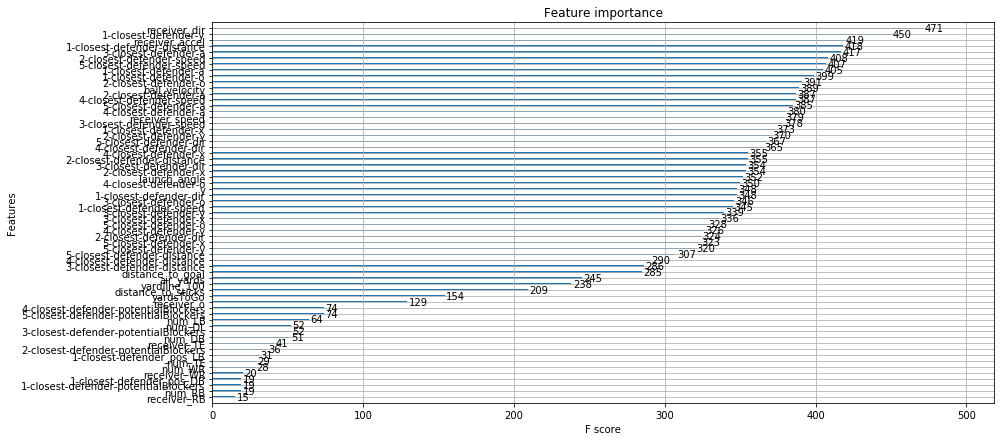

In [219]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 7)

xgb.plot_importance(bst)

In [220]:
def convert_output_to_predicted_yards(lis):
    e_value = 0
    for i,v in enumerate(lis):
        e_value += (i - 5) * v
    return e_value

ypred = bst.predict(dtrain)
y_vals = np.array(list(map(convert_output_to_predicted_yards, ypred)))


train["yac"] = a['yac'][:4000]
train['xyac_rish'] = y_vals
train['xyac_nflfastR'] = a['xyac_nflfastR'][:4000]
train.to_csv("training_predictions.csv")

x_rish_closer = 0
x_rish_diff = 0
fastr_closer = 0
faster_diff = 0

train = train.dropna()
for i,r in train.iterrows():
    if(abs(r['yac'] - r['xyac_rish']) < abs(r['yac'] - r['xyac_nflfastR'])):
        x_rish_closer += 1
        x_rish_diff += abs(r['yac'] - r['xyac_rish'])
    else:
        fastr_closer += 1
        faster_diff += abs(r['yac'] - r['xyac_nflfastR'])
        
        
print(fastr_closer, faster_diff)
print("Rishav's Model was closer %s number of times by an average of %s yards on train set" %(x_rish_closer, x_rish_diff/x_rish_closer))
print("FastR's Model was closer %s number of times by an average of %s yards on train set" % (fastr_closer, faster_diff/fastr_closer))


249 87.60931045900361
Rishav's Model was closer 3720 number of times by an average of 0.7245284952332236 yards on train set
FastR's Model was closer 249 number of times by an average of 0.3518446203172836 yards on train set


In [221]:
ypred = bst.predict(dtest)
y_vals = np.array(list(map(convert_output_to_predicted_yards, ypred)))


test["yac"] = a['yac'][4000:]
test['xyac_rish'] = y_vals

test['xyac_nflfastR'] = a['xyac_nflfastR'][4000:]
test.to_csv("test_predictions.csv")

x_rish_closer = 0
x_rish_diff = 0
fastr_closer = 0
faster_diff = 0

test = test.dropna()
for i,r in test.iterrows():
    if(abs(r['yac'] - r['xyac_rish']) < abs(r['yac'] - r['xyac_nflfastR'])):
        x_rish_closer += 1
        x_rish_diff += abs(r['yac'] - r['xyac_rish'])
    else:
        fastr_closer += 1
        faster_diff += abs(r['yac'] - r['xyac_nflfastR'])
        
        
print(fastr_closer, faster_diff)
print("Rishav's Model was closer %s number of times by an average of %s yards on test set" %(x_rish_closer, x_rish_diff/x_rish_closer))
print("FastR's Model was closer %s number of times by an average of %s yards on test set" % (fastr_closer, faster_diff/fastr_closer))


2805 7947.805226529599
Rishav's Model was closer 3910 number of times by an average of 2.488718722095524 yards on test set
FastR's Model was closer 2805 number of times by an average of 2.8334421484954007 yards on test set
